In [1]:
import pyodbc
import pandas as pd

In [2]:
from sqlalchemy import create_engine
import urllib

In [3]:
import pyodbc
print(pyodbc.drivers())

['SQL Server', 'ODBC Driver 17 for SQL Server', 'ODBC Driver 18 for SQL Server']


In [4]:
driver = 'ODBC Driver 17 for SQL Server'  
server = 'DESKTOP-NVBBECE\\RENAD_SQL'   
database = 'CustomerDataDB'


connection_string = f'DRIVER={{{driver}}};SERVER={server};DATABASE={database};Trusted_Connection=yes;'

In [11]:
# URL encode the connection string
params = urllib.parse.quote_plus(connection_string)
# Create SQLAlchemy engine
engine = create_engine(f'mssql+pyodbc:///?odbc_connect={params}')

# DATA EXTRACTION
try:
    df_customers = pd.read_sql("SELECT * FROM Customer;", engine)
    print(df_customers.head())

    df_transactions = pd.read_sql("SELECT * FROM trnsaction;", engine)
    print(df_transactions.head())

    df_Interaction = pd.read_sql("SELECT * FROM Interaction;", engine)
    print(df_Interaction.head())

    df_errorcustomer = pd.read_sql("SELECT * FROM error_customer;", engine)
    print(df_errorcustomer.head())

    df_transactionerror = pd.read_sql("SELECT * FROM transaction_error;", engine)
    print(df_transactionerror.head())

    df_errinteract = pd.read_sql("SELECT * FROM err_interact;", engine)
    print(df_errinteract.head())
    
except Exception as e:
    print("An error occurred:", e)


   CustomerID FirstName LastName                       Email     Phone  \
0           1     ayaat    ahmed     ayaat.ahmed@example.com  555-1111   
1           2     shahd    ahmed     shahd.ahmed@example.com  555-2222   
2           3    maryam  mohamed  maryam.mohamed@example.com  555-3333   
3           4     renad  haytham   renad.haytham@example.com  555-4444   
4           5     salma   ashraf    salma.ashraf@example.com  555-5555   

         Address  
0     123 Elm St  
1     456 Oak St  
2    789 Pine St  
3  101 Maple Ave  
4   202 Birch Rd  
   TransactionID  CustomerID  InteractionID TransactionDate  Amount
0              3           1              1      2024-09-01   100.0
1              4           2              2      2024-09-02   250.0
2              5           3              3      2024-09-03   300.0
3              6           4              4      2024-09-04    50.0
4              7           5              5      2024-09-05    75.0
   InteractionID  CustomerID Inte

In [13]:
#PREPARE DATA FOR ANALYSIS
#Check for null values
print(df_customers.isnull().sum())
print(df_transactions.isnull().sum())
print( df_Interaction.isnull().sum())

CustomerID    0
FirstName     0
LastName      0
Email         0
Phone         0
Address       0
dtype: int64
TransactionID      0
CustomerID         0
InteractionID      0
TransactionDate    0
Amount             0
dtype: int64
InteractionID      0
CustomerID         0
InteractionType    0
Date               0
Notes              0
dtype: int64


In [15]:
#remove duplicate values
df_customers.drop_duplicates(inplace=True)

<Axes: xlabel='Amount'>

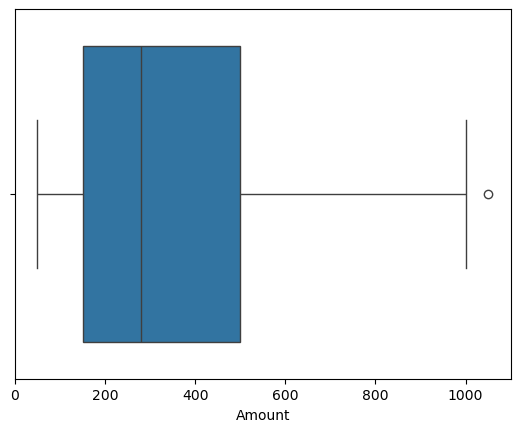

In [17]:
#Detect outliers using boxplots
import seaborn as sns
sns.boxplot(x=df_transactions['Amount'])

In [19]:
# Count the number of interactions per customer
customer_interactions = df_Interaction.groupby('CustomerID').size()
print(customer_interactions)

CustomerID
1     2
2     2
3     2
4     2
5     2
6     2
7     2
8     2
9     1
10    1
11    1
12    1
13    1
14    1
15    1
16    1
17    1
18    1
19    1
20    1
dtype: int64


In [49]:
# Ensure that the 'Date' column is in datetime format
df_Interaction['Date'] = pd.to_datetime(df_Interaction['Date'], errors='coerce')

# Check if there are any NaT (Not a Time) values after conversion
if df_Interaction['Date'].isnull().sum() > 0:
    print("Warning: Some dates could not be converted.")
    
# Extract month and year from date
df_Interaction['Month'] = df_Interaction['Date'].dt.to_period('M')
month_interactions = df_Interaction.groupby('Month').size()

print(month_interactions)

Month
2024-09    20
2024-10     8
Freq: M, dtype: int64


In [25]:
# count the number of interactions of each type.
interaction_counts = df_Interaction.groupby('InteractionType').size()
print(interaction_counts)

InteractionType
Chat           1
Email         10
In-Person      1
Meeting        6
Phone          2
Phone Call     7
Text           1
dtype: int64


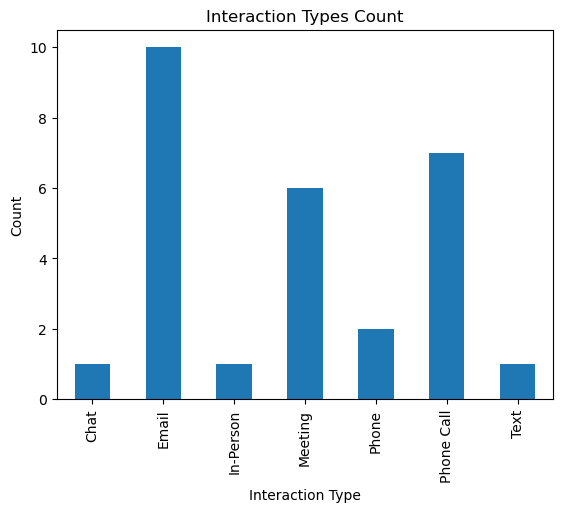

In [27]:
import matplotlib.pyplot as plt
interaction_counts.plot(kind='bar')
plt.title('Interaction Types Count')
plt.xlabel('Interaction Type')
plt.ylabel('Count')
plt.show()


In [29]:
# PREDICTIVE MODEL
#merge tables
df_combined = pd.merge(df_customers, df_Interaction, on='CustomerID', how='left')
df_combined = pd.merge(df_combined, df_transactions, on='CustomerID', how='left')
print(df_combined)

    CustomerID    FirstName  LastName                           Email  \
0            1        ayaat     ahmed         ayaat.ahmed@example.com   
1            1        ayaat     ahmed         ayaat.ahmed@example.com   
2            1        ayaat     ahmed         ayaat.ahmed@example.com   
3            1        ayaat     ahmed         ayaat.ahmed@example.com   
4            2        shahd     ahmed         shahd.ahmed@example.com   
5            2        shahd     ahmed         shahd.ahmed@example.com   
6            2        shahd     ahmed         shahd.ahmed@example.com   
7            2        shahd     ahmed         shahd.ahmed@example.com   
8            3       maryam   mohamed      maryam.mohamed@example.com   
9            3       maryam   mohamed      maryam.mohamed@example.com   
10           3       maryam   mohamed      maryam.mohamed@example.com   
11           3       maryam   mohamed      maryam.mohamed@example.com   
12           4        renad   haytham       renad.h

In [47]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


df_combined['Total_Interactions'] = df_combined.groupby('CustomerID')['InteractionID_x'].transform('count')
df_combined['Total_Transactions'] = df_combined.groupby('CustomerID')['TransactionID'].transform('count')
df_combined['Total_Amount_Spent'] = df_combined.groupby('CustomerID')['Amount'].transform('sum')
df_combined['Last_Transaction_Date'] = df_combined.groupby('CustomerID')['TransactionDate'].transform('max')
df_combined['Days_Since_Last_Transaction'] = (pd.Timestamp('2024-10-21') - df_combined['Last_Transaction_Date']).dt.days

# Label Creation: Assume churned if no transaction in last 30 days
df_combined['Churn'] = df_combined['Days_Since_Last_Transaction'].apply(lambda x: 1 if x > 30 else 0)
# Remove duplicates by CustomerID to have one row per customer
df_clean = df_combined.drop_duplicates(subset='CustomerID')

# Features and Target
X = df_clean[['Total_Interactions', 'Total_Transactions', 'Total_Amount_Spent', 'Days_Since_Last_Transaction']]
y = df_clean['Churn']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Training
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predictions for the test set
y_pred = model.predict(X_test)

# Output the results
results = pd.DataFrame({
    'CustomerID': df_clean.loc[X_test.index, 'CustomerID'],
    'Total_Interactions': df_clean.loc[X_test.index, 'Total_Interactions'],
    'Total_Amount_Spent': df_clean.loc[X_test.index, 'Total_Amount_Spent'],
    'Predicted_Churn': y_pred
})


print(results)

    CustomerID  Total_Interactions  Total_Amount_Spent  Predicted_Churn
30           9                   2               650.0                0
45          17                   1               210.0                1
0            1                   4               400.0                0
55         700                   0                 0.0                0
35          12                   2               740.5                0
